In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 



Using TensorFlow backend.


In [2]:
!wget 'https://raw.githubusercontent.com/Kulbear/stock-prediction/master/000002-from-1995-01-01.csv'

--2019-01-07 20:52:27--  https://raw.githubusercontent.com/Kulbear/stock-prediction/master/000002-from-1995-01-01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224023 (219K) [text/plain]
Saving to: ‘000002-from-1995-01-01.csv.1’

000002-from-1995-01 100%[===================>] 218.77K  --.-KB/s    in 0.04s   

2019-01-07 20:52:27 (5.38 MB/s) - ‘000002-from-1995-01-01.csv.1’ saved [224023/224023]



In [3]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


In [0]:
def feature_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [0]:
def data_preprocess(stock, seq_len):
  amount_of_features = len(stock.columns)
  data = stock.values

  sequence_length = seq_len + 1
  sequence = []
  for index in range(len(data) - sequence_length):
      sequence.append(data[index : index + sequence_length])

  sequence = np.array(sequence)
#   print (sequence.shape)
  row = (0.9 * sequence.shape[0])
  train = sequence[: int(row), :]
  test = sequence[int(row) :, :]

  train, test = feature_scaler(train, test)
  
#   test_test = test[:,-1, -1]
#   print (train.shape, test.shape, test_test.shape)

  X_train = train[:, : -1]
  y_train = train[:, -1][: ,-1]
  X_test = test[:, : -1]
  y_test = test[:, -1][ : ,-1]

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

  return [X_train, y_train, X_test, y_test]

  

In [0]:
X_train, y_train, X_test, y_test = data_preprocess(df, 20)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((4647, 20, 6), (4647,), (517, 20, 6), (517,))

In [0]:
def build_model(channel):
  
  model = Sequential()

  # By setting return_sequences to True we are able to stack another LSTM layer
  model.add(LSTM(input_dim=channel,output_dim=20,return_sequences=True))
  model.add(Dropout(0.4))

  model.add(LSTM(100,return_sequences=False))
  model.add(Dropout(0.3))

  model.add(Dense(output_dim=1))
  model.add(Activation("linear"))

  start = time.time()
  model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
  print("Compilation Time : ", time.time() - start)
  return model

In [9]:
window = 20
X_train, y_train, X_test, y_test = data_preprocess(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


X_train (4647, 20, 6)
y_train (4647,)
X_test (517, 20, 6)
y_test (517,)


In [10]:
channel = X_train.shape[2]

model = build_model(channel)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 6), units=20)`
  


Compilation Time :  0.034667253494262695


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  if sys.path[0] == '':


In [11]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=10,
    validation_split=0.1,
    verbose=2)

Train on 4182 samples, validate on 465 samples
Epoch 1/10
 - 3s - loss: 0.3813 - acc: 0.0000e+00 - val_loss: 0.1273 - val_acc: 0.0000e+00
Epoch 2/10
 - 1s - loss: 0.0962 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 3/10
 - 1s - loss: 0.0825 - acc: 0.0000e+00 - val_loss: 0.0461 - val_acc: 0.0000e+00
Epoch 4/10
 - 1s - loss: 0.0698 - acc: 0.0000e+00 - val_loss: 0.0449 - val_acc: 0.0000e+00
Epoch 5/10
 - 1s - loss: 0.0655 - acc: 0.0000e+00 - val_loss: 0.0399 - val_acc: 0.0000e+00
Epoch 6/10
 - 1s - loss: 0.0608 - acc: 0.0000e+00 - val_loss: 0.0424 - val_acc: 0.0000e+00
Epoch 7/10
 - 1s - loss: 0.0559 - acc: 0.0000e+00 - val_loss: 0.0634 - val_acc: 0.0000e+00
Epoch 8/10
 - 1s - loss: 0.0582 - acc: 0.0000e+00 - val_loss: 0.0376 - val_acc: 0.0000e+00
Epoch 9/10
 - 1s - loss: 0.0445 - acc: 0.0000e+00 - val_loss: 0.0418 - val_acc: 0.0000e+00
Epoch 10/10
 - 1s - loss: 0.0657 - acc: 0.0000e+00 - val_loss: 0.0471 - val_acc: 0.0000e+00


Train Score: 0.03 MSE
Test Score: 0.02 MSE


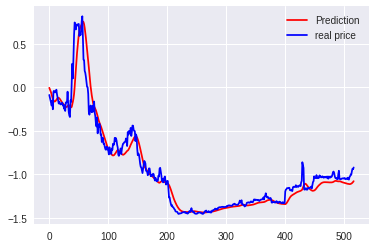

In [12]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE' % trainScore[0])

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE' % testScore[0])

pred = model.predict(X_test)

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='real price')
plt.legend(loc='upper right')
plt.show()